In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm_notebook

import torch
from torch.utils.data import DataLoader

from model_single_multi_label import AtlasResNet34, AtlasResNet18, predict_proba
from utils import load_checkpoint
from gpu_utils import set_n_get_device
from sklearn.metrics import f1_score as f1_score_sklearn
from dataset_single_multi_label import prepare_trainset, train_test_split, AtlasDataSet

%matplotlib inline

In [2]:
device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:2")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
#device = 'cpu'
#multi_gpu = [0, 1, 2, 3]#[1, 2]#None, 0, 1, 2, 3

# for blending model's selecting best threshold, use seed 2345 (it has best single model LB score)
SEED = 1234##2345 #5678#4567#3456#2345#1234
debug = False# if True, load 100 samples
BATCH_SIZE = 32
NUM_WORKERS = 20
IMG_SIZE = 512

## select best threshold for each class on validset

In [3]:
# load validset
fname_train, fname_valid = train_test_split(SEED, debug)
val_ds = AtlasDataSet(fname_valid, mode='train', augmentation=False, IMG_SIZE=IMG_SIZE)
val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        #sampler=sampler,
        num_workers=NUM_WORKERS,
    )

total trainset:  53527
IMG_SIZE:  512


In [4]:
# y should be makeup
y_valid = []
for i, (input_data, truth) in enumerate(val_dl):
    #if i==10:
    #    break
    y_valid.append(truth.cpu().numpy())
y_valid = np.concatenate(y_valid, axis=0)
y_valid.shape

(5353, 2)

In [5]:
# load trained model
net = AtlasResNet34(debug=False).cuda(device=device)
#net = AtlasResNet18(debug=False).cuda(device=device)
checkpoint_path = 'checkpoint/single_multi_label/RESNET34_512_v1_seed1234/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

raw_weight size:  torch.Size([64, 3, 7, 7])
new_weight size:  torch.Size([64, 4, 7, 7])


In [6]:
%%time
# predict_proba
net.set_mode('valid')
preds_valid = predict_proba(net, val_dl, device)#preds_valid2

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CPU times: user 59.5 s, sys: 17.3 s, total: 1min 16s
Wall time: 1min 23s


/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
No handles with labels found to put in legend.



Best threshold:  0.51


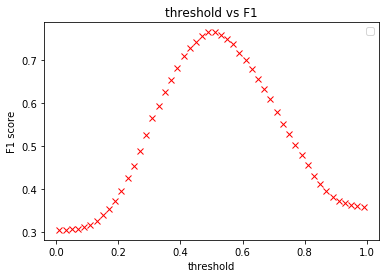

In [7]:
#
thresholds_candidates = np.linspace(0.01, 0.99, 50)
#print('threshold candidate: ', thresholds_candidates)

f1_score_best_list = []

preds_valid_sigmoid = 1 / (1 + np.exp(-preds_valid))#sigmoid of class-0/1

f1_scores = []
for threshold in tqdm_notebook(thresholds_candidates):
    preds_valid1 = (preds_valid_sigmoid[:, 1]>threshold).astype(np.int).reshape(-1, 1)
    preds_valid0 = 1 - preds_valid1
    preds_valid_arr = np.concatenate((preds_valid0, preds_valid1), axis=1)
    f1_score = f1_score_sklearn(y_true=y_valid, y_pred=preds_valid_arr, average='macro')
    f1_scores.append(f1_score)

# best threshold for this class
threshold_best_index = np.argmax(f1_scores)
f1_score_best = f1_scores[threshold_best_index]
threshold_best = thresholds_candidates[threshold_best_index]

print('Best threshold: ', threshold_best)

plt.plot(thresholds_candidates, f1_scores, "xr")
plt.xlabel("threshold")
plt.ylabel("F1 score")
plt.title("threshold vs F1")
plt.legend()

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
print(classification_report(y_valid[:, 1], (preds_valid_sigmoid[:, 1]>0.51).astype(np.int)))

             precision    recall  f1-score   support

          0       0.80      0.77      0.79      2999
          1       0.72      0.76      0.74      2354

avg / total       0.77      0.77      0.77      5353



In [25]:
from dataset_single_multi_label import get_label_data
train_label = get_label_data()

In [23]:
valid_df = pd.DataFrame({'Id': fname_valid, 
                         'is_single': (preds_valid_sigmoid[:, 1]>0.51).astype(np.int), 
                         'is_single_prob': preds_valid_sigmoid[:, 1]}, 
                        columns=['Id', 'is_single', 'is_single_prob'])

In [27]:
valid_df = valid_df.merge(train_label, on=['Id'])
valid_df.sort_values(by=['is_single_prob'], ascending=False, inplace=True)

In [31]:
valid_df['is_single_truth'] = valid_df.Target.apply(lambda x: len(x.split(' '))==1).astype(np.int)

In [47]:
valid_df.iloc[0:500, 4].mean()

0.928

In [105]:
valid_df.iloc[0:500, 3].value_counts()

23          79
7           54
0           43
4           39
25          39
3           34
6           32
2           26
21          23
5           22
11          20
19          20
18          10
26           6
25 21        4
24           4
1            4
20           3
25 7         3
22           2
25 6 1       2
17 5         2
2 0          2
14           2
22 21        1
23 1         1
23 2         1
6 7 0        1
16 25 17     1
25 4         1
24 18        1
17 21        1
6 23         1
11 2         1
22 0         1
25 0         1
22 3         1
5 0          1
18 21        1
6 1          1
24 21        1
13           1
7 0          1
23 0         1
25 6         1
0 21         1
7 5          1
16 25 5      1
12           1
Name: Target, dtype: int64

In [53]:
train_label.Target.value_counts()

4             2693
0             2414
6             2122
25 0          1998
5 0           1703
5             1685
23            1653
3             1503
25            1470
19            1227
7             1163
21            1058
11            1007
14            1007
2 0            996
1              829
2              808
0 21           769
25 4           692
7 0            668
25 5           619
19 0           615
22             611
1 0            573
23 0           572
18             566
3 0            497
12             487
25 5 0         437
25 21          425
              ... 
20 23            1
19 16 25         1
16 25 18         1
7 18 14 21       1
15 2 0           1
12 23 2          1
22 25 7 0        1
16 14 23 0       1
5 1 0 21         1
7 4 3            1
25 11 5          1
12 19 14         1
12 16 25 0       1
19 25 17 0       1
11 23 21         1
16 23 2          1
12 6             1
16 25 5 0        1
19 11 2          1
6 11 0           1
22 23 1          1
11 16       

## using best threshold to predict

In [56]:
from glob import glob

In [57]:
## ⚠️可能每次读取返回图片（样本）顺序不一样，所以保存的single model prediction可能顺序都不同，不同直接blend
files = glob('data/raw/test/*')
fname_test = list(set([f.replace('_red.png', '').replace('_green.png', '').replace('_blue.png', '').replace('_yellow.png', '').replace('data/raw/test/', '') for f in files]))
len(fname_test)

11702

In [58]:
test_ds = AtlasDataSet(fname_test, mode='test', augmentation=False, IMG_SIZE=IMG_SIZE)
test_dl = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        #sampler=sampler,
        num_workers=NUM_WORKERS,
    )

IMG_SIZE:  512


In [59]:
%%time
# predict by single model
preds_test_single_multi_label = predict_proba(net, test_dl, device)

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CPU times: user 1min 57s, sys: 34 s, total: 2min 31s
Wall time: 2min 57s


In [62]:
preds_test_sigmoid = 1 / (1 + np.exp(- preds_test_single_multi_label))#sigmoid of class-0/1

preds_test1 = (preds_test_sigmoid[:, 1]>threshold_best).astype(np.int)

In [63]:
single_multi_label_df = pd.DataFrame({'is_single_label': preds_test1, 'Id': fname_test, 
                                      'is_single_label_prob': preds_test_sigmoid[:, 1]}, 
                                     columns=['Id', 'is_single_label', 'is_single_label_prob'])

In [225]:
df = pd.read_csv('submissions/582_best_model_with_leak259.csv.gz', compression='gzip')

In [220]:
df = df.merge(single_multi_label_df, on=['Id']).sort_values(by=['is_single_label_prob'], ascending=False)
df['is_single_from_cnn'] = df.Predicted.apply(lambda x: len(x.split(' '))==1).astype(np.int)
df.head(2)

,Id,Predicted,is_single_label,is_single_label_prob,is_single_from_cnn
8590,bb98d760-bace-11e8-b2b8-ac1f6b6435d0,19 25,1,0.987850,0
10462,e498262c-bad6-11e8-b2b9-ac1f6b6435d0,19 25,1,0.986453,0


In [221]:
# for predicted single label with top probabilities, pick single label by CNN classifier's sigmoid probabilities
df_check = df.loc[df.is_single_from_cnn==0, ].iloc[0:1000, ]

_out = []
_pick = []
for i in df_check.index:
    _fname = df_check.loc[i, 'Id']
    _c = [int(item) for item in df_check.loc[i, 'Predicted'].split(' ')]
    _prob_arr = prob_cnn[_fname]
    _prob_arr = 1 / (1 + np.exp(-_prob_arr))#sigmoid
    _prob = [_prob_arr[c] for c in _c]
    _pick_label = [c for i,c in enumerate(_c) if _prob_arr[c]>0.5]
    if _pick_label==[]:
        _idx = np.argmax(_prob)
        _pick_label = str(_c[_idx])#[_c[_idx]]
        _pick.append(_pick_label)
    else:
        _pick.append(' '.join(str(item) for item in _pick_label))#_pick_label
    _out.append(_prob)    
df_check['prob'] = _out
df_check['pick_label'] = _pick

#for i in df_check.index:
    #df_check.loc[i, 'pick_label'] = ' '.join(str(item) for item in df_check.loc[i, 'pick_label'])

In [222]:
df_check

,Id,Predicted,is_single_label,is_single_label_prob,is_single_from_cnn,prob,pick_label
8590,bb98d760-bace-11e8-b2b8-ac1f6b6435d0,19 25,1,0.987850,0,"[0.6876748, 0.80890524]",19 25
10462,e498262c-bad6-11e8-b2b9-ac1f6b6435d0,19 25,1,0.986453,0,"[0.47319576, 0.70961916]",25
4701,675aea42-bac6-11e8-b2b7-ac1f6b6435d0,21 25,1,0.979564,0,"[0.8065429, 0.42942283]",21
10125,dd15543e-bacb-11e8-b2b8-ac1f6b6435d0,23 25,1,0.975807,0,"[0.17201893, 0.28663057]",25
6262,891bf0e8-bacd-11e8-b2b8-ac1f6b6435d0,6 25,1,0.975766,0,"[0.2769938, 0.45020238]",25
7878,ac52ddf4-bad4-11e8-b2b8-ac1f6b6435d0,6 25,1,0.961149,0,"[0.31098738, 0.4553294]",25
10224,df6c1104-bad1-11e8-b2b8-ac1f6b6435d0,23 25,1,0.954591,0,"[0.65177554, 0.45591643]",23
4403,615727e2-bad9-11e8-b2b9-ac1f6b6435d0,14 17,1,0.952719,0,"[0.47292715, 0.76711863]",17
2644,3b1f4292-bad6-11e8-b2b9-ac1f6b6435d0,17 25,1,0.950322,0,"[0.47535184, 0.9463851]",25
1399,1ecb1a9e-bad1-11e8-b2b8-ac1f6b6435d0,14 17,1,0.947530,0,"[0.9838006, 0.7055471]",14 17


In [223]:
# replace sub
cnt = 0
sub = pd.read_csv('submissions/582_best_model_with_leak259.csv.gz', compression='gzip')
for i in sub.index:
    _fname = sub.loc[i, 'Id']
    _raw_label = sub.loc[i, 'Predicted']
    if _fname in df_check.Id.tolist():
        _replace = df_check.loc[df_check.Id==_fname, 'pick_label'].values[0]
        if _replace!=_raw_label:
            sub.loc[i, 'Predicted'] = _replace
            cnt += 1
print('replace: ', cnt)

replace:  407


In [230]:
sub.to_csv('submissions/best_model_replace_with_single_label_v1.csv.gz', compression='gzip', index=False)

In [110]:
# load preds
with open('prediction/1222_v2_blending1234_2345_3456_4567_5678.pkl', 'rb') as f:
    null_z, null_a, _preds_test0, _preds_test1, _preds_test2, \
    null_b, null_c, _fname_test0 = pickle.load(f)
idx = np.argsort(_fname_test0)
_preds_test0 = _preds_test0[idx, :]
_preds_test1 = _preds_test1[idx, :]
_preds_test2 = _preds_test2[idx, :]
_preds_test = (_preds_test0 + _preds_test1 + _preds_test2) / 3


# with open('prediction/RESNET18_v2_seed1234.pkl', 'rb') as f:
#     preds_test3, null_d, fname_test1 = pickle.load(f)
# idx = np.argsort(fname_test1)
# preds_test += preds_test3[idx, :]

#preds_test = preds_test / 4
_fname_test = np.array(_fname_test0)[idx].tolist()

In [117]:
prob_cnn = dict((_fname, _preds_test[i, :]) for i, _fname in enumerate(_fname_test))

In [94]:
# loading
with open('prediction/1222_v2_blending1234_2345_3456.pkl', 'rb') as f:
    _, thresholds_ensemble = pickle.load(f)

with open('prediction/1222_v2_seed2345.pkl', 'rb') as f:
    preds_test3, thresholds_single, fname_test1 = pickle.load(f)
idx = np.argsort(fname_test1)
preds_test3 = preds_test3[idx, :]

In [95]:
# predict class using class-specific-thresholds
preds_test01 = (preds_test > thresholds_ensemble).astype(np.int)

# predict class using another model, to fillna for the ensemble model
preds_test02 = (preds_test3 > thresholds_single).astype(np.int)

# predict class using threshold=0.3
#preds_test01 = (torch.sigmoid(torch.from_numpy(preds_test)) > 0.3).numpy().astype(np.int)

In [100]:
## fill na for the ensemble model by single model's prediction for those na images
preds_test01[(preds_test01.sum(axis=1)==0), :] = preds_test02[(preds_test01.sum(axis=1)==0), :]

In [23]:
def encode_2str(arr, fillna=True):
    s = ''
    for i in range(28):
        _s = arr[i]
        if _s==1:
            if s=='':
                s = str(i)
            else:
                s += ' '
                s += str(i)
    if s=='':#sample that predict 0 for all 28 classes
        if fillna:
            s = np.random.choice(['0', '25'], 1)[0]
        else:
            s = '-1'
    return s

In [103]:
output = []
for pred in preds_test01:
    output.append(encode_2str(pred, fillna=True))#False

In [51]:
# for single model
preds_test01 = (preds_test > thresholds).astype(np.int)
#preds_test01 = (torch.sigmoid(torch.from_numpy(preds_test)) > 0.4).numpy().astype(np.int)

output = []
for pred in preds_test01:
    output.append(encode_2str(pred, fillna=True))#False

In [52]:
pd.value_counts(output)

0               1110
0 25             988
25               754
23               425
21               403
0 2              361
7                333
0 21             326
0 21 25          280
21 25            248
0 7              215
2                214
5                195
4                179
6                175
0 5              174
11               172
14               165
0 2 25           162
19               137
0 23             131
3                124
0 1              121
0 19             118
1                111
2 25             103
0 3               89
23 25             87
18                86
0 7 25            69
                ... 
0 1 23 25          1
0 2 15             1
0 1 21 22          1
7 21 22 25         1
14 16 19           1
5 7 25             1
3 5 21             1
0 15               1
1 6 21             1
16 21 22 25        1
0 11 21 25         1
0 5 12             1
0 2 20             1
0 3 19             1
2 14 16 17         1
16 18 25           1
14 17 18 21  

## submit

In [53]:
sub = pd.DataFrame({'Id': fname_test, 'Predicted':output}, columns=['Id', 'Predicted'])
sub.sort_values(by=['Id'], inplace=True)
sub.reset_index(drop=True, inplace=True)

In [54]:
sub.head(5)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 17 18
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25


In [55]:
#print(sub_name)
sub.to_csv('submissions/RESNET34_256_v2_seed1234.csv.gz', compression='gzip', index=False)

In [32]:
sub.Predicted.value_counts()

0 25           1254
0              1236
25             1119
23              434
21              389
7               323
21 25           281
0 2             271
0 21            245
0 21 25         245
2               226
5               221
4               198
14              182
0 7             180
6               174
19              166
0 5             160
11              151
0 19            144
3               132
0 2 25          129
0 23            127
23 25           125
1               104
2 25            103
6 25            101
0 1              91
7 25             87
0 3              84
               ... 
4 13 22           1
0 12 23           1
3 21 23 25        1
1 7               1
12 14             1
3 5 21            1
0 5 26            1
0 1 22            1
5 18              1
0 1 19            1
18 23 25          1
12 21 22 25       1
11 21             1
0 22 23 25        1
0 6 23 25         1
7 17 25           1
2 5 6 25          1
5 24 25           1
6 9 22 25         1


## is there leak images?

In [2]:
import pandas as pd
import numpy as np

In [3]:
leak = pd.read_csv('data/raw/leak/TestEtraMatchingUnder_259_R14_G12_B10.csv')
external_data = pd.read_csv('data/raw/external_data.csv')

In [23]:
leak['Extra'] = ['_'.join(fname.split('_')[1:]) for fname in leak.Extra]

In [30]:
leak = leak[['Extra', 'Test']].drop_duplicates('Test')
leak.head(2)

,Extra,Test
0,44431_556_B9_1,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0
1,35086_383_E8_7,5661665e-bacf-11e8-b2b8-ac1f6b6435d0


In [35]:
external_data = external_data.rename(columns={'Id': 'Extra'})
external_data.head(2)

,Extra,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21


In [37]:
leak = leak.merge(external_data, on=['Extra'], how='left')[['Test', 'Target']]

In [39]:
leak.head(2)

,Test,Target
0,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0,25 18 0
1,5661665e-bacf-11e8-b2b8-ac1f6b6435d0,25 17 0


In [72]:
# best LB by model
sub = pd.read_csv('submissions/577_blending_seed1234_2345_3456_fillna_seed2345.csv.gz')
sub.head(2)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5


In [73]:
cnt = 0
for i in leak.index:
    fname = leak.loc[i, 'Test']
    leak_target = leak.loc[i, 'Target']
    pred_target = sub.loc[sub.Id==fname, 'Predicted'].values[0]
    if sorted(leak_target.split(' ')) != sorted(pred_target.split(' ')):
        print(sorted(leak_target.split(' ')), ' vs ', sorted(pred_target.split(' ')))
        sub.loc[sub.Id==fname, 'Predicted'] = leak_target
        cnt += 1
cnt

['2', '23']  vs  ['25']
['0', '21', '23']  vs  ['0', '21', '25']
['0', '14']  vs  ['0', '14', '25']
['0']  vs  ['0', '16']
['21']  vs  ['0', '16', '21']
['1', '2']  vs  ['2']
['12', '13']  vs  ['13']
['2', '21', '26', '4']  vs  ['2', '26', '4']
['0', '25']  vs  ['0', '25', '6']
['14', '16', '25']  vs  ['16', '25']
['0', '21', '22']  vs  ['21', '25', '7']
['25']  vs  ['16', '21', '25']
['13']  vs  ['13', '21']
['13']  vs  ['0', '19']
['13']  vs  ['0', '25', '5']
['21', '25']  vs  ['25', '7']
['2', '22']  vs  ['0', '22']
['21', '4']  vs  ['4']
['21', '4']  vs  ['4']
['2']  vs  ['7']
['11', '2']  vs  ['0', '11', '2']
['0', '19']  vs  ['18', '19']
['0', '19']  vs  ['19']
['0', '19']  vs  ['18', '19', '5']
['12', '21', '25']  vs  ['12', '25']
['0', '14']  vs  ['0', '14', '16']
['0', '14']  vs  ['14', '16']
['1', '5']  vs  ['1']
['0']  vs  ['25', '4', '5']
['21']  vs  ['0', '21']
['0']  vs  ['0', '16']
['14', '25']  vs  ['0', '14']
['14']  vs  ['0', '14']
['14']  vs  ['0', '14', '16']
['25']

145

In [78]:
#sub2 = sub.copy()

In [77]:
#(sub2.Predicted!=sub.Predicted).sum()

In [60]:
sub.to_csv('submissions/best_model_with_leak259.csv.gz', compression='gzip', index=False)

In [80]:
145/len(sub2.index)

0.012391044265937446